In [289]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [290]:
day=pd.read_csv("day.csv")
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [291]:
day.shape

(731, 16)

In [292]:
day.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [293]:
day.rename(columns={'instant':'rec_id','dteday':'datetime','yr':'year','mnth':'month','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_count'},inplace=True)
day.head()

,rec_id,datetime,season,year,month,holiday,weekday,workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


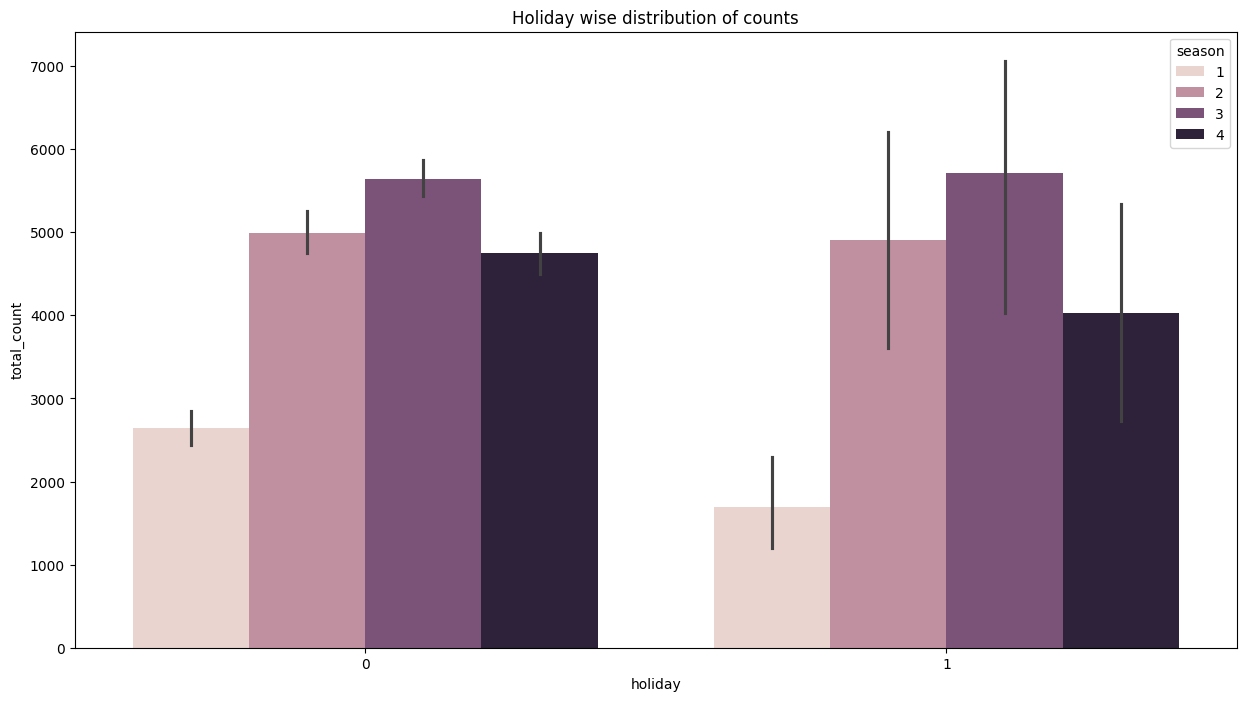

In [294]:
fig,ax=plt.subplots(figsize=(15,8))
#Barplot for Holiday distribution of counts
sns.barplot(data=day,x='holiday',y='total_count',hue='season')
ax.set_title('Holiday wise distribution of counts')
plt.show()

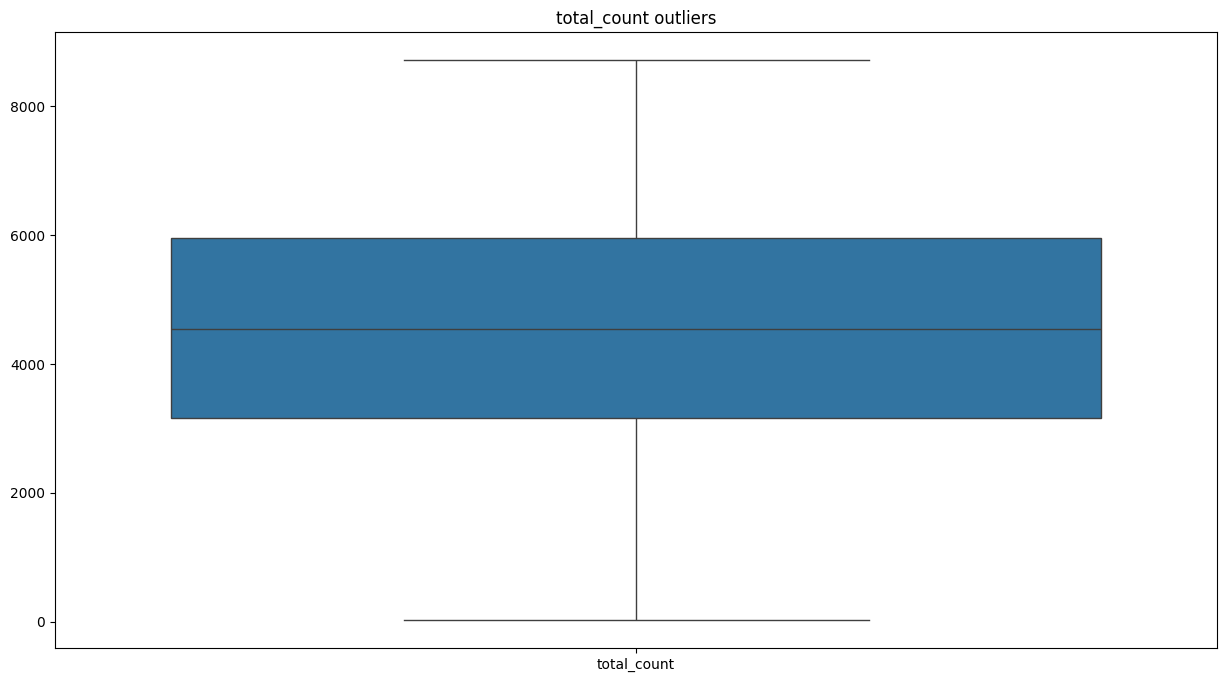

In [295]:
#CHECK FOR OUTLIERS IN THE DATA
fig,ax=plt.subplots(figsize=(15,8))
sns.boxplot(data=day[['total_count']])
ax.set_title('total_count outliers')
plt.show()

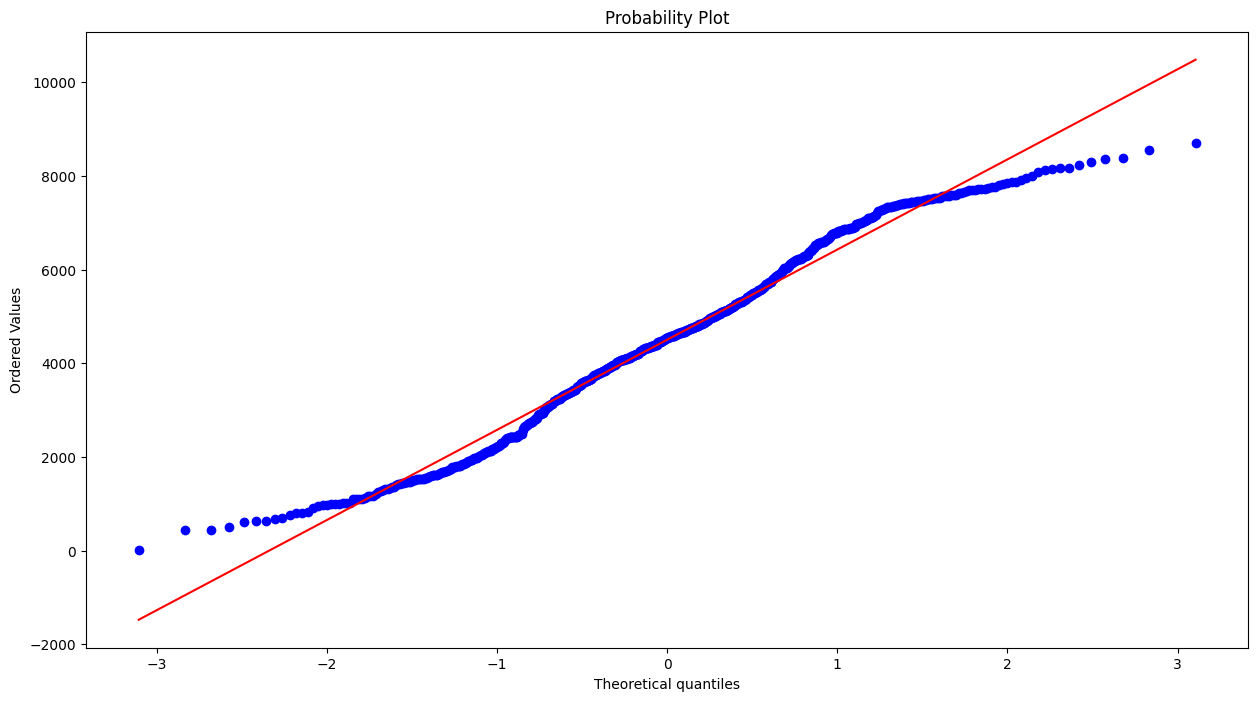

In [296]:
import scipy
from scipy import stats
#Normal plot
fig=plt.figure(figsize=(15,8))
stats.probplot(day.total_count.tolist(),dist='norm',plot=plt)
plt.show()

<Axes: >

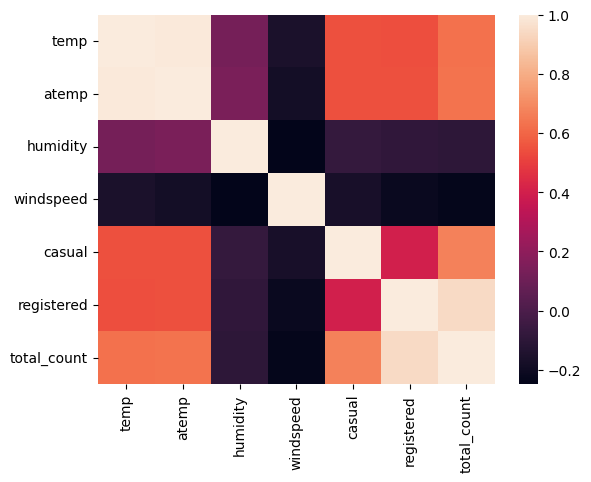

In [297]:
correMtr=day[["temp","atemp","humidity","windspeed","casual","registered","total_count"]].corr()
sns.heatmap(correMtr)

In [298]:
day=day.drop(columns=['rec_id','datetime','atemp','casual','registered'])
day.head()

,season,year,month,holiday,weekday,workingday,weather_condition,temp,humidity,windspeed,total_count
0,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600


In [299]:
x=day.drop(columns='total_count')
y=day['total_count']

In [300]:
from sklearn.model_selection  import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [301]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

In [302]:
def evaluate_model(true,predicted):
    mae=mean_absolute_error(true,predicted)
    mse=mean_squared_error(true,predicted)
    rmse=np.sqrt(mean_squared_error(true,predicted))
    r2_square=r2_score(true,predicted)
    return mae,rmse,r2_square

In [303]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 878.4199
- Mean Absolute Error: 652.8254
- R2 Score: 0.7895
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 879.3812
- Mean Absolute Error: 648.6003
- R2 Score: 0.8071


Lasso
Model performance for Training set
- Root Mean Squared Error: 878.4305
- Mean Absolute Error: 652.6089
- R2 Score: 0.7895
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 879.6314
- Mean Absolute Error: 649.2118
- R2 Score: 0.8070


Ridge
Model performance for Training set
- Root Mean Squared Error: 878.4254
- Mean Absolute Error: 652.7336
- R2 Score: 0.7895
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 879.4854
- Mean Absolute Error: 649.0718
- R2 Score: 0.8071


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 725.2869
- Mean Absolute Error: 499.6212
- R2 Score: 0.

In [304]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.881132
5,Random Forest Regressor,0.855590
6,XGBRegressor,0.841095
0,Linear Regression,0.807149
2,Ridge,0.807103
1,Lasso,0.807039
8,AdaBoost Regressor,0.777305
4,Decision Tree,0.776052
3,K-Neighbors Regressor,0.753968


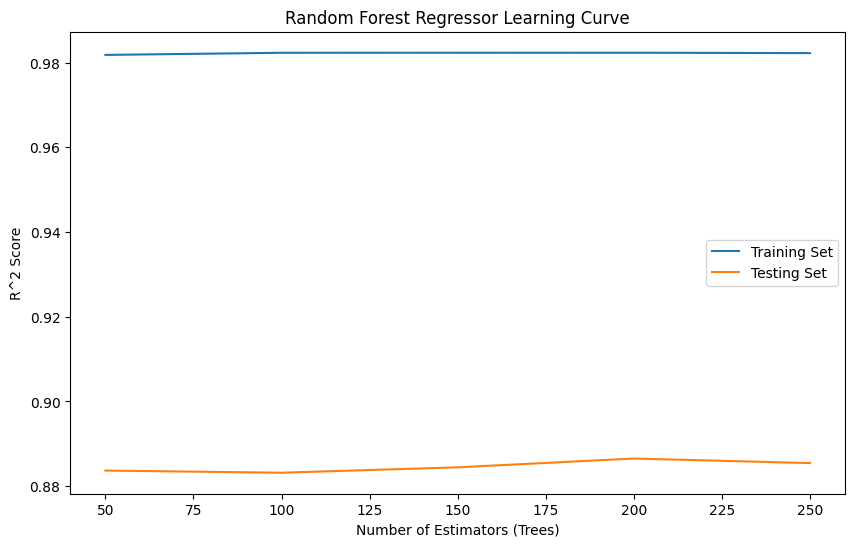

In [305]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your feature matrix X and target variable y

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define a range of n_estimators values to try
n_estimators_values = [50, 100, 150, 200, 250]

train_scores = []
test_scores = []

for n_estimators in n_estimators_values:
    # Create the RandomForestRegressor model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    
    # Train the model
    rf_model.fit(x_train, y_train)
    
    # Make predictions on training and testing sets
    y_train_pred = rf_model.predict(x_train)
    y_test_pred = rf_model.predict(x_test)
    
    # Calculate R^2 scores
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    
    # Append scores to lists
    train_scores.append(train_score)
    test_scores.append(test_score)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_scores, label='Training Set')
plt.plot(n_estimators_values, test_scores, label='Testing Set')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('R^2 Score')
plt.title('Random Forest Regressor Learning Curve')
plt.legend()
plt.show()


In [306]:
lin_model = RandomForestRegressor(n_estimators=200,random_state=42,max_depth=15)
lin_model = lin_model.fit(x_train, y_train)
y_pred = lin_model.predict(x_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.72


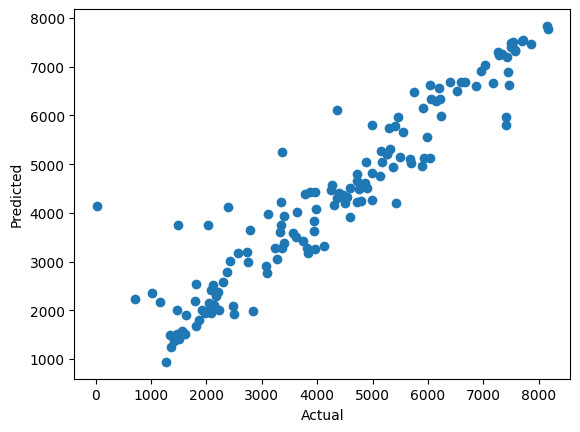

In [307]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

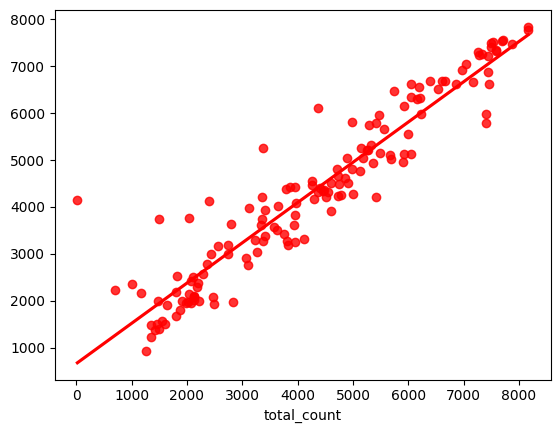

In [308]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [309]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
703,6606,6681.150250,-75.150250
33,1550,1572.270833,-22.270833
300,3747,3423.295000,323.705000
456,6041,5124.347500,916.652500
633,7538,7511.225482,26.774518
...,...,...,...
70,2132,2093.365000,38.635000
192,4258,4459.710585,-201.710585
328,2792,3640.390000,-848.390000
165,5180,5045.996761,134.003239
